# Import libraries and data

In [1]:
# import libraries 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from matplotlib_venn import venn2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from utils import increase_stringency_CSF, get_uniprot

# ignore pandas copy warning
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
data_path = os.getcwd() + "/Datasets/"
fig_path = os.getcwd() + "/Figures/"

## Brain elevated feature data set

In [3]:
df_features_original = pd.read_csv(data_path + "/Features/df_features_brain_elevated_MS_filtered.csv")
df_features_original[:5]

,Uniprot,Sequence,Length,Molecular weight,A,C,D,E,F,G,...,PS01186,PS00232,PS00237,PS00028,PS00027,RNA_binding,DNA_binding,Ectodomain_shedding,EV,CSF
0,Q99569,MPAPEQASLVEEGQPQTRQEAASTGPGMEPETTATTILASVKEQEL...,1192,131866.7406,0.064597,0.011745,0.046980,0.050336,0.015940,0.061242,...,0,0,0,0,0,0,0,0,1,-1
1,Q7L8C5,MVLSVPVIALGATLGTATSILALCGVTCLCRHMHPKKGLLPRDQDP...,426,46884.2716,0.084507,0.025822,0.042254,0.070423,0.014085,0.058685,...,0,0,0,0,0,0,0,0,0,-1
2,Q9BT88,MAEITNIRPSFDVSPVVAGLIGASVLVVCVSVTVFVWSCCHQQAEK...,431,48296.3314,0.039443,0.016241,0.064965,0.048724,0.034803,0.060325,...,0,0,0,0,0,0,0,0,0,1
3,Q5DID0,MLRTSGLALLALVSAVGPSQASGFTEKGLSLLGYQLCSHRVTHTVQ...,1318,144292.2583,0.064492,0.033384,0.036419,0.059939,0.031108,0.072079,...,0,0,0,0,0,0,0,0,0,-1
4,Q8TBG9,MCMVIFAPLFAIFAFATCGGYSGGLRLSVDCVNKTESNLSIDIAFA...,265,29165.8331,0.071698,0.022642,0.033962,0.037736,0.086792,0.075472,...,0,0,0,0,0,0,0,0,0,-1


In [4]:
col_dict = {"Disorder_NSP":"Disorder", 
            "Helix_NSP":"Helix", 
            "Coil_NSP":"Coil",
            "Sheet_NSP":"Sheet",
            "ExpAA":"TM residues", 
            "First60ExpAA":"First 60 TM residues", 
            "PredHel":"TM region",
            "PredHel_binary":"TM region (binary)",
            "Cell_membrane":"Cell membrane", 
            "Endoplasmic_reticulum":"Endoplasmic reticulum", 
            "Mitochondrion":"Mitochondrion",
            "Golgi_apparatus":"Golgi apparatus",                          
            "NetNGlyc":"N-linked Glycosylation (NetNGlyc)",
            "GlycoMine_N":"N-linked Glycosylation (GlycoMine)", 
            "GlycoMine_O":"O-linked Glycosylation (GlycoMine)", 
            "GlycoMine_C":"C-linked Glycosylation (GlycoMine)",
            "RNA_binding":"RNA binding", 
            "DNA_binding":"DNA binding", 
            "Ectodomain_shedding":"Ectodomain shedding protein",
            "PS00022":"EGF1",
            "PS01186":"EGF2",
            "PS00232":"Cadherin-1",
            "PS00237":"G-protein receptor F1",
            "PS00027":"Homeobox",
            "PS00028":"Zinc Finger C2H2"}

df_features = df_features_original.rename(columns=col_dict)

In [5]:
df_features["log2(Molecular weight)"] = np.log2(df_features["Molecular weight"])

## CSF data set

In [6]:
csf = pd.read_csv(data_path + "CSF/CSF.csv")

## DeepLoc-1.0 prediction results

In [7]:
deeploc = pd.read_csv(data_path + "Features/DeepLoc_results_human_proteome.txt", sep="\t")
deeploc.rename(columns={"ID":"Uniprot"}, inplace=True)

# retrieve Uniprot ID
deeploc["Uniprot"] = deeploc["Uniprot"].apply(get_uniprot)

# Create data subsets

In [8]:
# create more stringent data sets
n = 2
print("Minimum number of studies in which a proteins was detected:", n)
df_features_CSF2 = increase_stringency_CSF(df_features, csf, n)
print("Number of proteins in dataset:", len(df_features_CSF2))
print("-------------")
n = 3
print("Minimum number of studies in which a proteins was detected:", n)
df_features_CSF3 = increase_stringency_CSF(df_features, csf, 3)
print("Number of proteins in dataset:", len(df_features_CSF3))

Minimum number of studies in which a proteins was detected: 2
Number of CSF proteins to be removed: 243
Number of CSF proteins left: 649
Number of proteins in dataset: 1836
-------------
Minimum number of studies in which a proteins was detected: 3
Number of CSF proteins to be removed: 367
Number of CSF proteins left: 525
Number of proteins in dataset: 1712


In [9]:
# create non-CSF and CSF protein subsets
non_CSF = df_features[df_features["CSF"] == -1]
CSF1 = df_features[df_features["CSF"] == 1]
CSF2 = df_features_CSF2[df_features_CSF2["CSF"] == 1]
CSF3 = df_features_CSF3[df_features_CSF3["CSF"] == 1]

df_list = [non_CSF, CSF1, CSF2, CSF3]
df_names = ["non-CSF", "CSF1+", "CSF2+", "CSF3+"]
df_colours = ["firebrick", "skyblue", "steelblue", "darkcyan"]

# Feature Analysis

In [10]:
# plot categorical variables

def get_percentages(df_list, feature):
    """
    """
    perc_list = []
    for i in range(len(df_list)):
        perc_list.append(sum(df_list[i][feature])/len(df_list[i]))

    return perc_list


def plot_percentages(features, df_list, df_names, df_colours, sharey=True):
    """
    """
    sns.set(style=("ticks"), font_scale=1.2)
    fig, ax = plt.subplots(1, len(features), figsize=(5*len(features), 5), sharey=sharey)

    for i in range(len(features)):
        bars = ax[i].bar(x=df_names, height=get_percentages(df_list, features[i]), color=df_colours, edgecolor="black")
        ax[i].bar_label(bars, fmt="%.4f")
        if i == 0:
            ax[i].set(ylabel="Fraction", title=features[i])
        else:
            ax[i].set(ylabel=None, title=features[i])
    
    return fig, ax

## Feature correlation with CSF class

In [11]:
# calculate pairwise correlation
corr_all = df_features.corr()
# reset index (feature names) as column
corr_CSF = corr_all[["CSF"]].sort_values(by="CSF", ascending=False)[1:].reset_index()

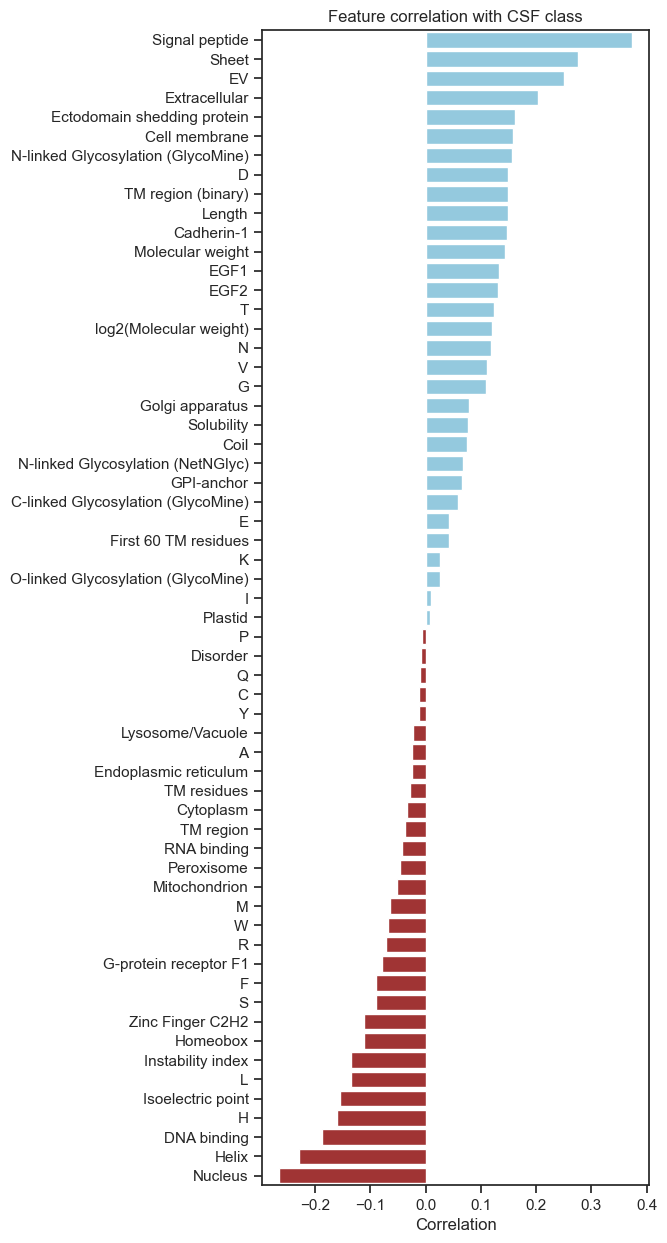

In [12]:
sns.set(style=("ticks"), font_scale=1)
fig, ax = plt.subplots(1, 1, figsize=(5,15)) 
ax.set_ylim((-0.3, 0.4))

# set colors
col_CSF = ["skyblue" if (x > 0) else "firebrick" for x in corr_CSF["CSF"]]

sns.barplot(x="CSF", y="index", data=corr_CSF, palette=col_CSF, orient="h", ax=ax)
ax.set(xlabel="Correlation", ylabel=None, title="Feature correlation with CSF class")

plt.show()
fig.savefig(fig_path + "Feature_correlation_CSF_brain_elevated.png", bbox_inches="tight", dpi=300, transparent=True)

## Subcellular localization

In [13]:
def get_loc_fraction(df, deeploc_df):
    """
    """
    df_loc = pd.DataFrame(df[["Uniprot"]].merge(deeploc_df[["Uniprot", "Location"]], on="Uniprot")["Location"])
    loc_fraction = df_loc.value_counts(normalize=True, dropna=False)
    loc_fraction.index = loc_fraction.index.get_level_values(0)
    loc_fraction = loc_fraction.reindex(["Cell_membrane", "Extracellular", "Golgi_apparatus", "Lysosome/Vacuole", 
        "Peroxisome", "Plastid", "Endoplasmic_reticulum", "Mitochondrion", "Cytoplasm", "Nucleus"])
    
    return loc_fraction.to_frame()

loc_fraction_non_CSF = get_loc_fraction(non_CSF, deeploc)
loc_fraction_CSF1 = get_loc_fraction(CSF1, deeploc)
loc_fraction_CSF2 = get_loc_fraction(CSF2, deeploc)
loc_fraction_CSF3 = get_loc_fraction(CSF3, deeploc)

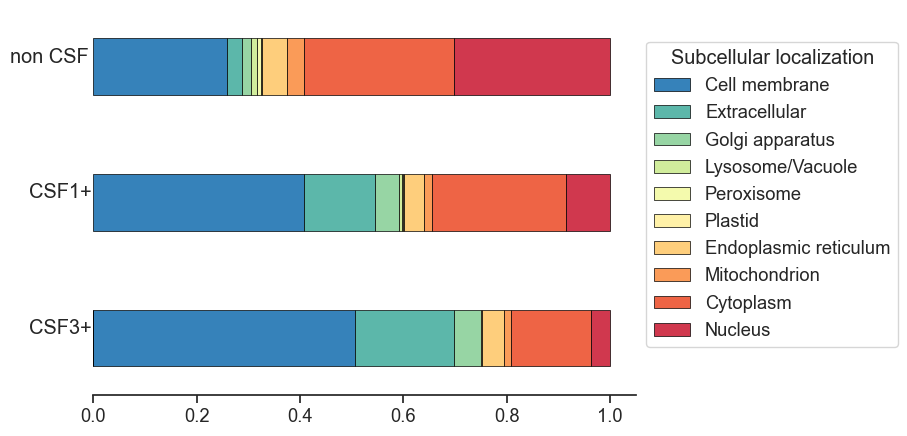

In [14]:
sns.set(style=("ticks"), font_scale=1.2, palette=sns.color_palette("Spectral_r", 10))
fig, ax = plt.subplots(3, 1, figsize=(7, 5))

loc_fraction_non_CSF.T.plot.barh(stacked=True, edgecolor="black", linewidth=0.5, ax=ax[0])
ax[0].set_ylabel("non CSF              ", rotation=0)
loc_fraction_CSF1.T.plot.barh(stacked=True, edgecolor="black", linewidth=0.5, ax=ax[1])
ax[1].set_ylabel("CSF1+          ", rotation=0)
loc_fraction_CSF3.T.plot.barh(stacked=True, edgecolor="black", linewidth=0.5, ax=ax[2])
ax[2].set_ylabel("CSF3+          ", rotation=0)

handles, labels = ax[2].get_legend_handles_labels()
labels = ["Cell membrane", "Extracellular", "Golgi apparatus", "Lysosome/Vacuole", 
        "Peroxisome", "Plastid", "Endoplasmic reticulum", "Mitochondrion", "Cytoplasm", "Nucleus"]
ax[2].legend(title="Subcellular localization", handles=handles, labels=labels, loc="upper right", 
    bbox_to_anchor=(1.5, 3.2))

# remove axes and ticks from upper plots
for i in range(2):
    ax[i].get_legend().remove()
    ax[i].set(xticks=[])
    ax[i].spines["bottom"].set_visible(False)
for i in range(3):
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["left"].set_visible(False)
    ax[i].set(yticklabels=[None], yticks=[])
    
visible_ticks = {"top": False}
plt.tick_params(axis="x", which="both", **visible_ticks)    

plt.show()
fig.savefig(fig_path + "Subcellular_localization_fraction.png", bbox_inches="tight", dpi=300, transparent=True)

## Conventional protein secretion pathway

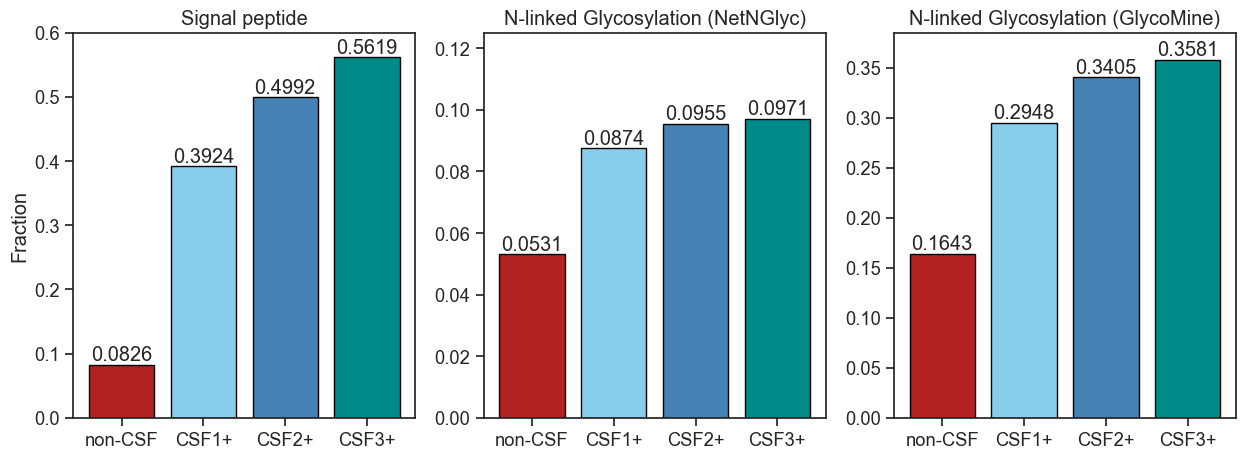

In [15]:
features = ["Signal peptide", "N-linked Glycosylation (NetNGlyc)", "N-linked Glycosylation (GlycoMine)"]

fig, ax = plot_percentages(features, df_list, df_names, df_colours, sharey=False)

# readjust y-axis limits
ax[0].set(ylim=(0,0.6))
ax[1].set(ylim=(0,0.125))
ax[2].set(ylim=(0,0.385))

plt.show()
fig.savefig(fig_path + "Fraction_conventional_secretion_brain_elevated.png", bbox_inches="tight", dpi=300, transparent=True)

## Glycosylation

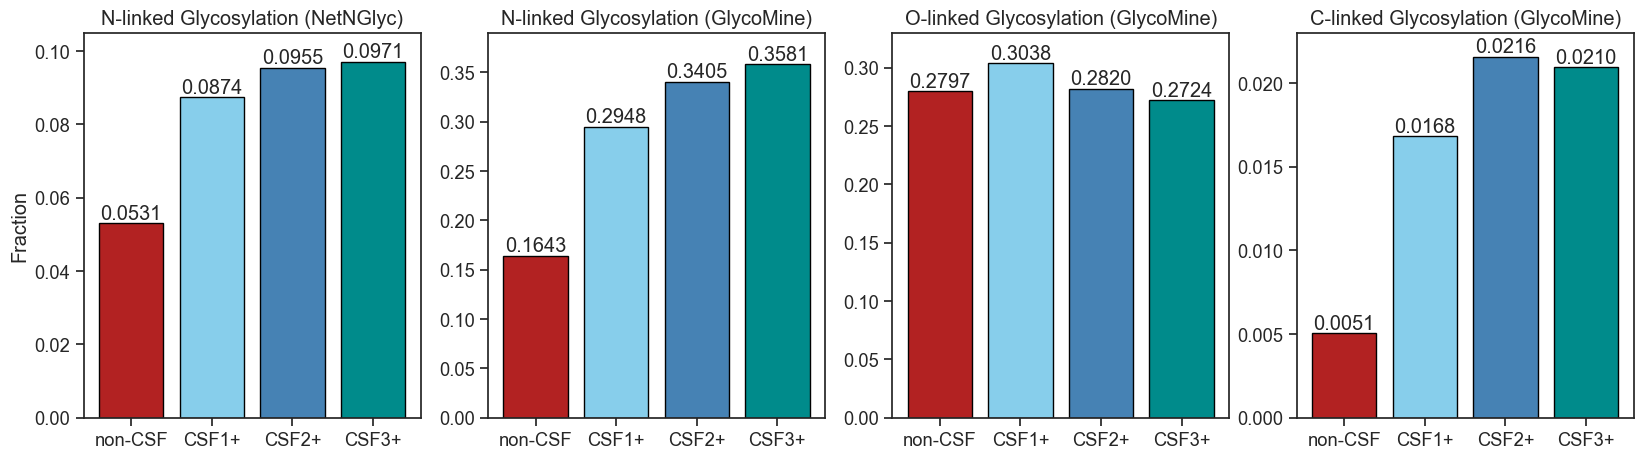

In [16]:
features = ["N-linked Glycosylation (NetNGlyc)", "N-linked Glycosylation (GlycoMine)", "O-linked Glycosylation (GlycoMine)", 
            "C-linked Glycosylation (GlycoMine)"]

fig, ax = plot_percentages(features, df_list, df_names, df_colours, sharey=False)

# readjust y-axis limits
ax[0].set(ylim=(0,0.105))
ax[1].set(ylim=(0,0.39))
ax[2].set(ylim=(0,0.33))
ax[3].set(ylim=(0,0.023))

plt.show()
fig.savefig(fig_path + "Fraction_glycosylation_brain_elevated.png", bbox_inches="tight", dpi=300, transparent=True)

## Transmembrane

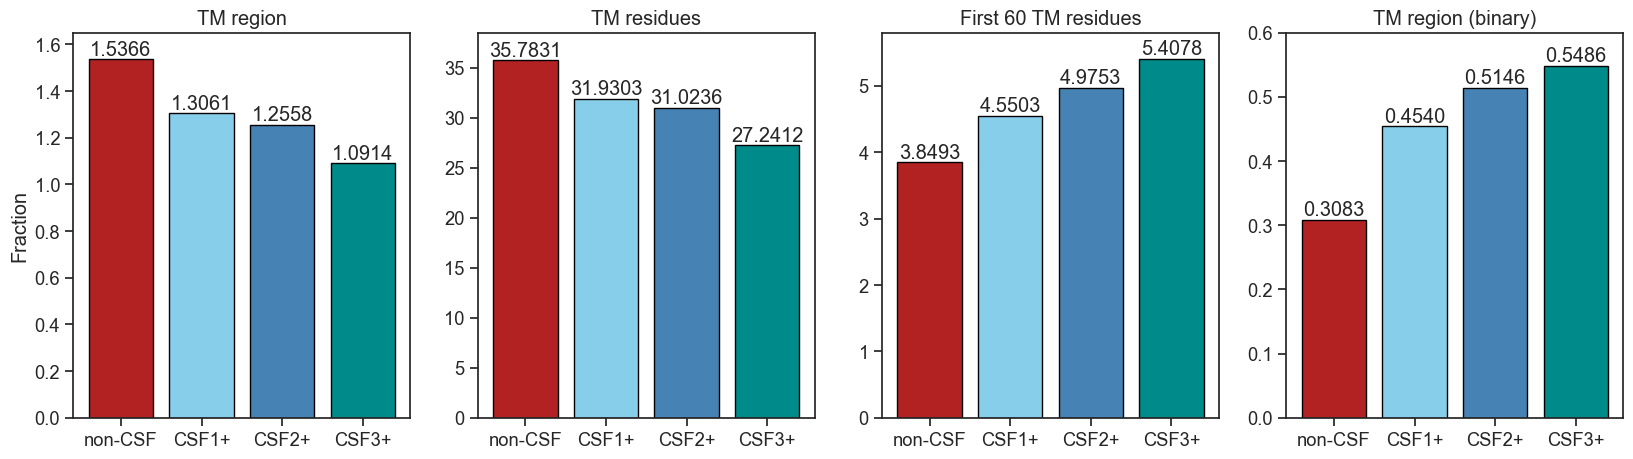

In [17]:
features = ["TM region", "TM residues", "First 60 TM residues", "TM region (binary)"]

fig, ax = plot_percentages(features, df_list, df_names, df_colours, sharey=False)

# readjust y-axis limits
ax[0].set(ylim=(0,1.65))
ax[1].set(ylim=(0,38.5))
ax[2].set(ylim=(0,5.8))
ax[3].set(ylim=(0,0.6))

plt.show()
fig.savefig(fig_path + "Fraction_transmembrane_brain_elevated.png", bbox_inches="tight", dpi=300, transparent=True)

In [18]:
# create empty dataframe 
tm_df = pd.DataFrame()

# add proportions of transmembrane region counts to dataframe
for i, data in enumerate(df_list):
    tm = pd.Series(data["TM region"].value_counts(normalize=True).sort_index(), name=df_names[i])
    tm_df = pd.merge(tm_df, tm, left_index=True, right_index=True, how="outer")
    
tm_df.reset_index(inplace=True)
tm_df["index"] = tm_df["index"].astype(int)

# aggregate values of all proteins with >7 predicted transmembrane regions
tm_df_8plus = tm_df[8:].agg([sum])
# add aggregated values to transmembrane dataframe (remove single values for aggregated values)
tm_df = pd.concat([tm_df[:8], tm_df_8plus])
tm_df.loc["sum", "index"] = ">7"

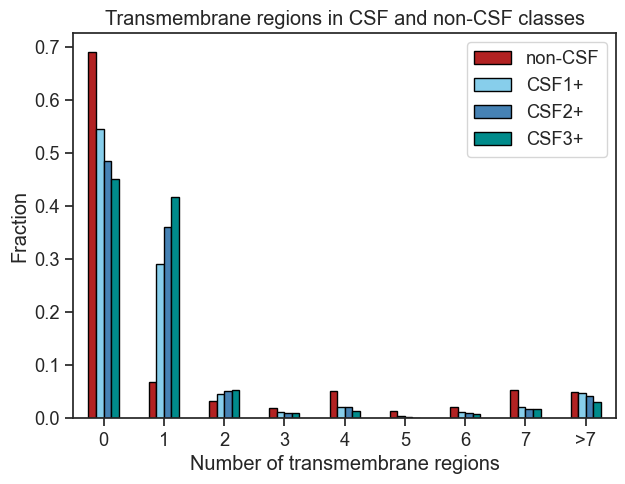

In [19]:
sns.set(style=("ticks"), font_scale=1.2)
fig, ax = plt.subplots(figsize=(7, 5))

tm_df.plot(x="index", y=df_names, kind="bar", color=df_colours, edgecolor="black", ax=ax)
ax.set(xlabel="Number of transmembrane regions", ylabel="Fraction", 
    title="Transmembrane regions in CSF and non-CSF classes")
ax.tick_params(axis="x", labelrotation=0)

plt.show()   
fig.savefig(fig_path + "Fraction_transmembrane_regions_brain_elevated.png", bbox_inches="tight", dpi=300, transparent=True)

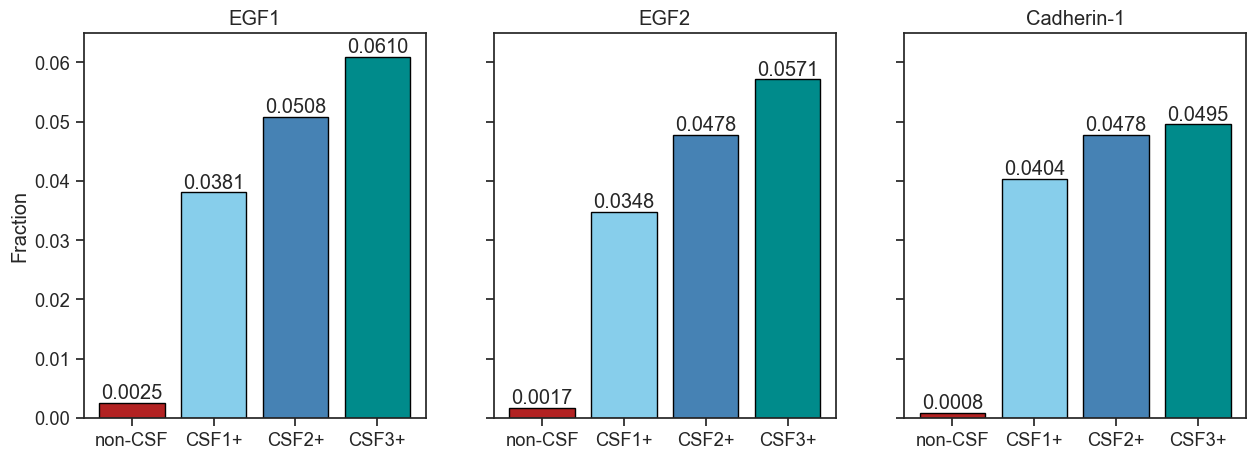

In [20]:
features = ["EGF1", "EGF2", "Cadherin-1"]

fig, ax = plot_percentages(features, df_list, df_names, df_colours, sharey=True)

# readjust y-axis limits
ax[0].set(ylim=(0,0.065))

plt.show()
fig.savefig(fig_path + "Fraction_motifs_CSF_enriched_brain_elevated.png", bbox_inches="tight", dpi=300, transparent=True)

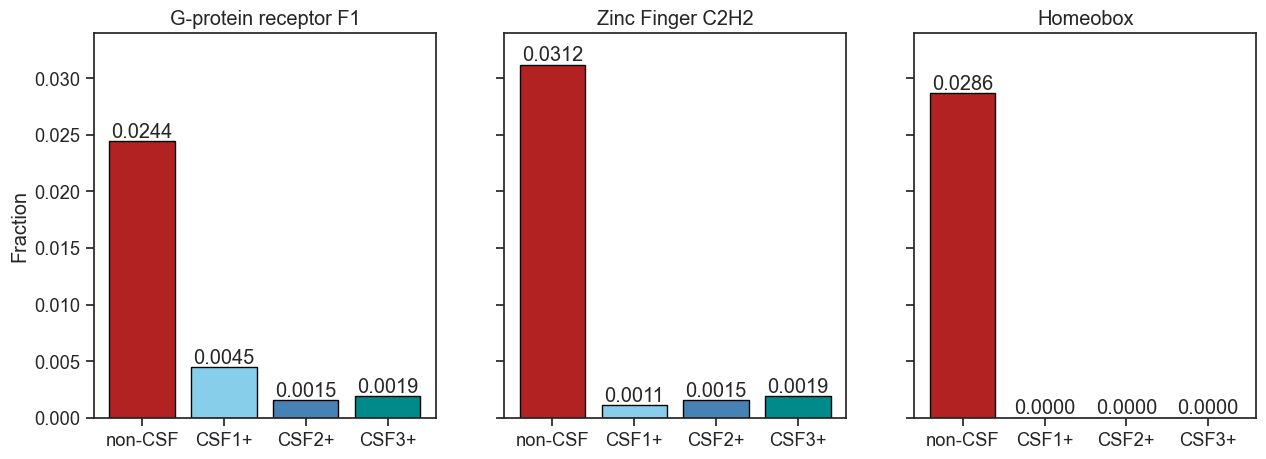

In [21]:
features = ["G-protein receptor F1", "Zinc Finger C2H2", "Homeobox"]

fig, ax = plot_percentages(features, df_list, df_names, df_colours, sharey=True)

# readjust y-axis limits
ax[0].set(ylim=(0,0.034))

plt.show()
fig.savefig(fig_path + "Fraction_motifs_non_CSF_enriched_brain_elevated.png", bbox_inches="tight", dpi=300, transparent=True)

## Annotations

### Nucleotide binding

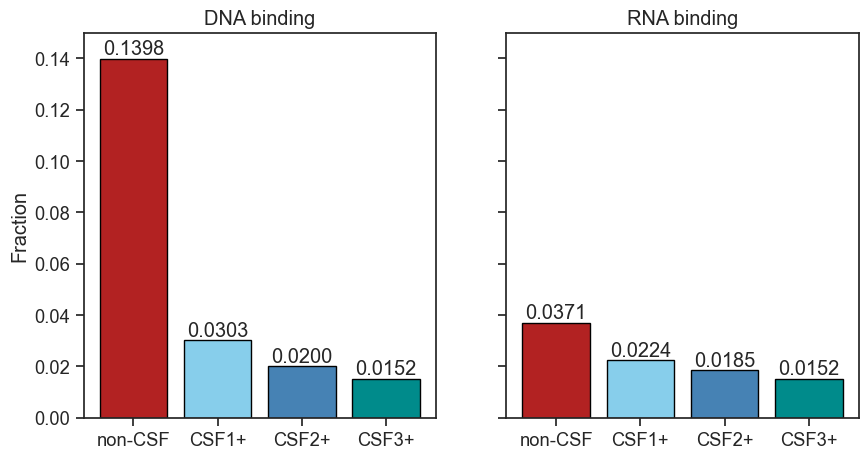

In [22]:
features = ["DNA binding", "RNA binding"]

fig, ax = plot_percentages(features, df_list, df_names, df_colours, sharey=True)

# readjust y-axis limits
ax[0].set(ylim=(0,0.15))

plt.show()
fig.savefig(fig_path + "Fraction_nucleotide_binding_brain_elevated.png", bbox_inches="tight", dpi=300, transparent=True)

### Membrane association

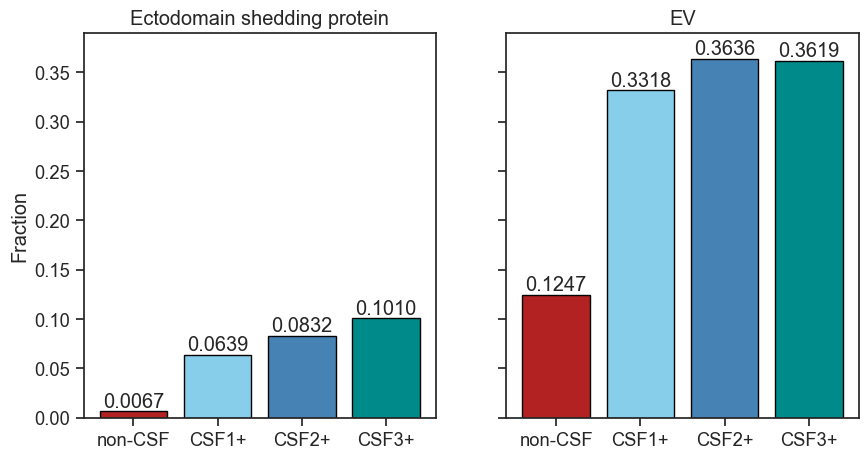

In [23]:
features = ["Ectodomain shedding protein", "EV"]

fig, ax = plot_percentages(features, df_list, df_names, df_colours, sharey=True)

# readjust y-axis limits
ax[0].set(ylim=(0,0.39))

plt.show()
fig.savefig(fig_path + "Fraction_membrane_association_annot_brain_elevated.png", bbox_inches="tight", dpi=300, transparent=True)

## Continuous features

In [24]:
def create_concatenated_df(feature, df_list, df_names):
    """
    """
    df_feature_list = []
    names = df_names
    
    # subset for feature and add category column
    for i, df in enumerate(df_list):
        df_feature = df[[feature]]
        df_feature["Category"] = names[i]
        df_feature_list.append(df_feature)
    
    # concatenate results
    df_concatenated = pd.concat(df_feature_list)
        
    return df_concatenated


def plot_distribution(feature, df_list, df_names, df_colours):
    """
    """
    
    df_concatenated = create_concatenated_df(feature, df_list, df_names)
    
    sns.set(style=("ticks"), font_scale=1.2)
    fig, ax = plt.subplots(1, 1, figsize=(6,4))
    sns.violinplot(y=feature, x="Category", data=df_concatenated, palette=df_colours)
    ax.set(xlabel=None)
    
    return fig, ax

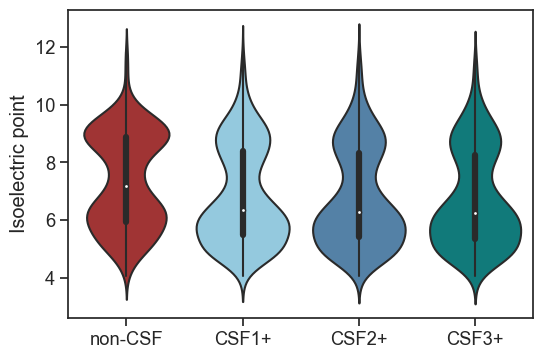

In [25]:
fig, ax = plot_distribution("Isoelectric point", df_list, df_names, df_colours)

plt.show()
fig.savefig(fig_path + "Distribution_iP_brain_elevated.png", bbox_inches="tight", dpi=300, transparent=True)

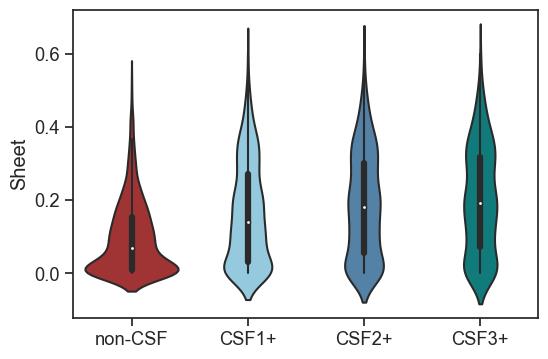

In [26]:
fig, ax = plot_distribution("Sheet", df_list, df_names, df_colours)

plt.show()
fig.savefig(fig_path + "Distribution_sheet_brain_elevated.png", bbox_inches="tight", dpi=300, transparent=True)

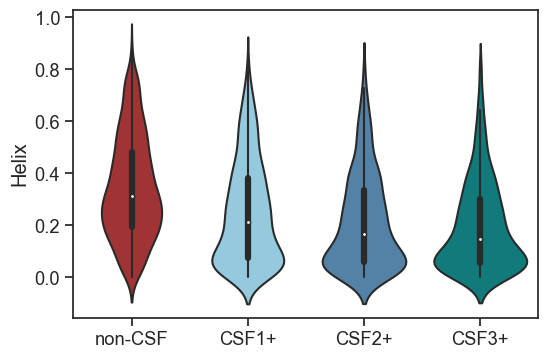

In [27]:
fig, ax = plot_distribution("Helix", df_list, df_names, df_colours)

plt.show()
fig.savefig(fig_path + "Distribution_helix_brain_elevated.png", bbox_inches="tight", dpi=300, transparent=True)

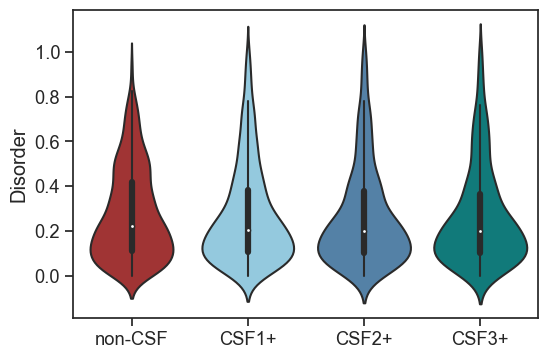

In [28]:
fig, ax = plot_distribution("Disorder", df_list, df_names, df_colours)

plt.show()
fig.savefig(fig_path + "Distribution_disorder_brain_elevated.png", bbox_inches="tight", dpi=300, transparent=True)

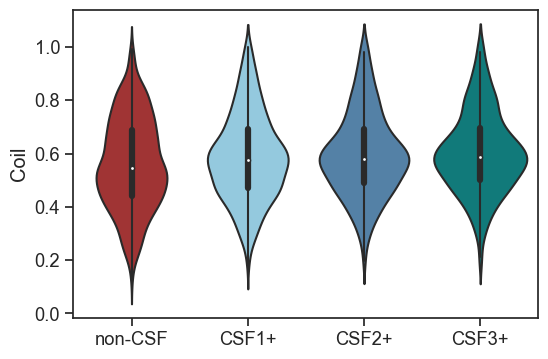

In [29]:
fig, ax = plot_distribution("Coil", df_list, df_names, df_colours)

plt.show()
fig.savefig(fig_path + "Distribution_coil_brain_elevated.png", bbox_inches="tight", dpi=300, transparent=True)

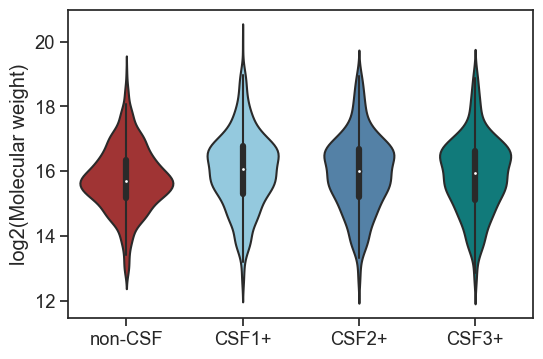

In [30]:
fig, ax = plot_distribution("log2(Molecular weight)", df_list, df_names, df_colours)

plt.show()
fig.savefig(fig_path + "Distribution_molecular_weight_brain_elevated.png", bbox_inches="tight", dpi=300, transparent=True)

# Principal Component Analysis

In [31]:
# merge features with study count
df_features_study_count = df_features_original.merge(csf[["Uniprot", "#Studies"]], on="Uniprot", how="left")
df_features_study_count.fillna(0, inplace=True)

In [32]:
# define continuous variables
cont = ["Length", "Molecular weight", "A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", 
        "V", "W", "Y", "Isoelectric point", "Instability index", "Solubility", "Disorder_NSP", "Helix_NSP", "Coil_NSP", 
        "Sheet_NSP", "ExpAA", "First60ExpAA", "PredHel"]

X = df_features_study_count.copy()
X.drop(["Uniprot", "Sequence", "CSF", "#Studies"], axis=1, inplace=True)
X[cont] = StandardScaler().fit_transform(X[cont])

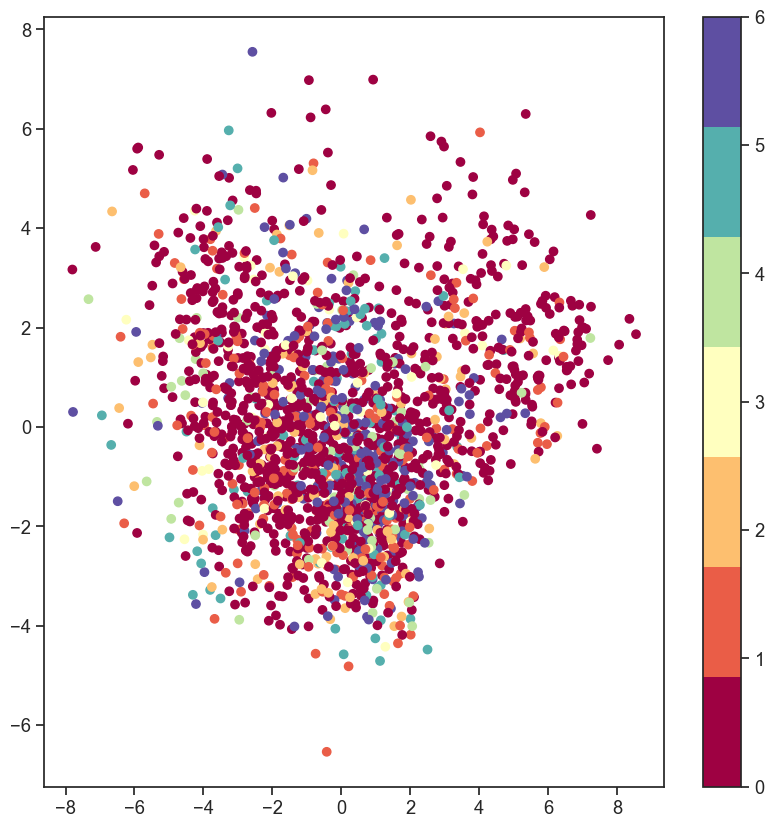

In [33]:
sns.set(style=("ticks"), font_scale=1.2)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

pca = PCA(n_components=2)
Xt = pca.fit_transform(X)
plt.scatter(Xt[:,0], Xt[:,1], c=df_features_study_count["#Studies"], cmap=plt.cm.get_cmap("Spectral", 7))
plt.colorbar()

plt.show()
fig.savefig(fig_path + "PCA_study_count.png", bbox_inches="tight", dpi=300, transparent=True)